In [8]:
import scipy.stats as sts


def trunc_norm_pdf(xvals, mu, sigma, cut_lb=None, cut_ub=None):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is given, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given, this function does
    the same thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))

    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)

    return pdf_vals

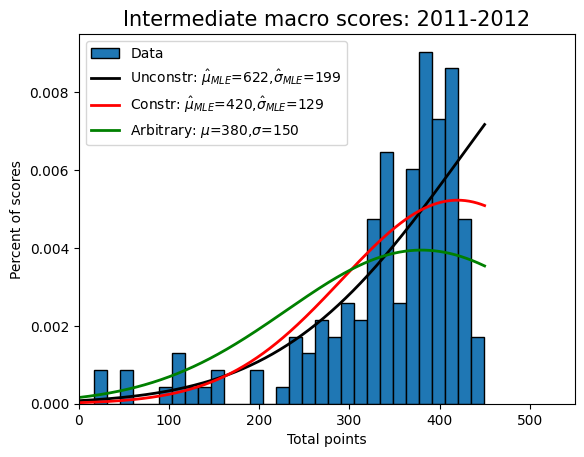

In [9]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import requests

# Download and save the data file Econ381totpts.txt as NumPy array
url = ('https://raw.githubusercontent.com/OpenSourceEcon/CompMethods/' +
       'main/data/gmm/Econ381totpts.txt')
data_file = requests.get(url, allow_redirects=True)
# open('../../../data/gmm/Econ381totpts.txt', 'wb').write(data_file.content)
data = np.loadtxt(url)
# if data_file.status_code == 200:
#     # Load the downloaded data into a NumPy array
#     data = np.loadtxt('../../../data/gmm/Econ381totpts.txt')
# else:
#     print('Error downloading the file')

# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(data, num_bins, density=True,
                                edgecolor='k', label='Data')
plt.title('Intermediate macro scores: 2011-2012', fontsize=15)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

# Plot the unconstrained MLE estimated distribution
dist_pts = np.linspace(0, 450, 500)
mu_MLE = 622.16
sig_MLE = 198.76
plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_MLE, sig_MLE, 0, 450),
    linewidth=2, color='k',
    label='Unconstr: $\hat{\mu}_{MLE}$=622,$\hat{\sigma}_{MLE}$=199'
)

# Plot the constrained MLE estimated distribution
mu_MLE_constr = 420.0
sig_MLE_constr = 129.04
plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_MLE_constr, sig_MLE_constr, 0, 450),
    linewidth=2, color='r',
    label='Constr: $\hat{\mu}_{MLE}$=420,$\hat{\sigma}_{MLE}$=129'
)

# Plot smooth line with distribution 1
mu_1 = 380
sig_1 = 150
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_1, sig_1, 0, 450),
         linewidth=2, color='g', label='Arbitrary: $\mu$=380,$\sigma$=150')

plt.legend(loc='upper left')

plt.show()

In [10]:
import scipy.integrate as intgr

def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()

    return mean_data, var_data


def model_moments(mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()

    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)

    return mean_model, var_model


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()

    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data

    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()

    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err

    return crit_val

In [11]:
import scipy.optimize as opt

# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 400
sig_init = 60
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (data, 0.0, 450.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args))
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print("")
print("SciPy.optimize.minimize results are the following:")
print(results)

mu_GMM1= 622.0452990166551  sig_GMM1= 198.72061662986494

SciPy.optimize.minimize results are the following:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.655313683558977e-18
        x: [ 6.220e+02  1.987e+02]
      nit: 19
      jac: [-3.197e-13  1.266e-12]
     nfev: 87
     njev: 29
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [12]:
mean_data, var_data = data_moments(data)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 450.0)
err1 = err_vec(data, mu_GMM1, sig_GMM1, 0.0, 450.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)

Mean of points = 341.90869565217395 , Variance of points = 7827.997292398056
Mean of model = 341.90869510461044 , Variance of model = 7827.997290042595
Error vector= [-1.60149042e-09 -3.00902151e-10]


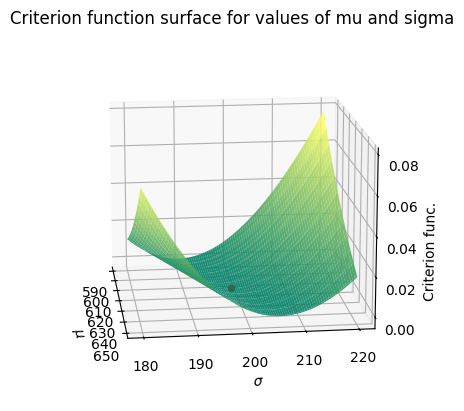

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
cmap1 = matplotlib.colormaps.get_cmap('summer')

critfunc_GMM1 = criterion(np.array([mu_GMM1, sig_GMM1]),
                          data, 0.0, 450.0, W_hat)

mu_vals = np.linspace(590, 650, 90)
sig_vals = np.linspace(180, 220, 100)
critfunc_vals = np.zeros((90, 100))
for mu_ind in range(90):
    for sig_ind in range(100):
        critfunc_vals[mu_ind, sig_ind] = \
            criterion(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                      data, 0.0, 450.0, W_hat)[0][0]

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(mu_mesh.T, sig_mesh.T, critfunc_vals, rstride=8,
                cstride=1, cmap=cmap1, alpha=0.9)
ax.scatter(mu_GMM1, sig_GMM1, critfunc_GMM1, color='red', marker='o',
           s=18, label='GMM estimate')
ax.view_init(elev=15, azim=-7, roll=0)
ax.set_title('Criterion function surface for values of mu and sigma')
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')
ax.set_zlabel(r'Criterion func.')

plt.show()

In [14]:
import numpy.linalg as lin

def Jac_err2(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    This function computes the Jacobian matrix of partial derivatives of the
    R x 1 moment error vector e(x|theta) with respect to the K parameters
    theta_i in the K x 1 parameter vector theta. The resulting matrix is the
    R x K Jacobian.
    '''
    Jac_err = np.zeros((2, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = (
        (err_vec(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
         err_vec(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) /
        (2 * h_mu)
    ).flatten()
    Jac_err[:, 1] = (
        (err_vec(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
         err_vec(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) /
        (2 * h_sig)
    ).flatten()

    return Jac_err

N = data.shape[0]
d_err2 = Jac_err2(data, mu_GMM1, sig_GMM1, 0.0, 450.0, False)
print("Jacobian matrix of derivatives")
print(d_err2)
print("")
print("Weighting matrix")
print(W_hat)
SigHat2 = (1 / N) * lin.inv(d_err2.T @ W_hat @ d_err2)
print("")
print("Sigma hat squared")
print(SigHat2)
print("")
print("Standard errors")
print('Std. err. mu_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2[1, 1]))

Jacobian matrix of derivatives
[[ 0.00057977 -0.00191677]
 [-0.00244916  0.00973172]]

Weighting matrix
[[1. 0.]
 [0. 1.]]

Sigma hat squared
[[680416.53881955 172529.79775418]
 [172529.79775418  43810.64699633]]

Standard errors
Std. err. mu_hat= 824.8736502153246
Std. err. sig_hat= 209.30993047709578
